In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xarray as xr
import pandas as pd
from glob import glob
from keras.models import load_model
from deepsky.gan import stack_gen_encoder, unscale_multivariate_data, rescale_multivariate_data
import keras.backend as K
from os.path import join
import matplotlib.colors as colors


In [7]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    data_files = sorted(glob(join(data_path, "*.nc")))
    for data_file in data_files:
        print(data_file)
        ds = xr.open_dataset(data_file)
        patch_arr = []
        for variable in variable_names:
            patch_arr.append(ds[variable].values)
        data_patches.append(np.stack(patch_arr, axis=-1))
    data = np.vstack(data_patches)
    return data

In [8]:
variable_names = ["composite_reflectivity_entire_atmosphere_prev",
                  "temperature_2_m_above_ground_prev",
                  "dew_point_temperature_2_m_above_ground_prev",
                  "u-component_of_wind_10_m_above_ground_prev",
                  "v-component_of_wind_10_m_above_ground_prev"]
storm_data = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", variable_names)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc
/scr

In [12]:
rescaled_storm_data = rescale_multivariate_data(storm_data)

In [21]:
max_vals = storm_data.max(axis=0).max(axis=0).max(axis=0)
min_vals = storm_data.min(axis=0).min(axis=0).min(axis=0)

In [ ]:
patch_files = sorted(glob("/scratch/dgagne/storm_gan_20170424/gan_gen_patches*.nc"))

In [ ]:
out_path = "/scratch/dgagne/storm_gan_images_20170424/"
for patch_file in patch_files:
    print(patch_file)
    patches = xr.open_dataset(patch_file)
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    fig, axes = plt.subplots(6, 6, figsize=(12, 12))
    plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
    cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
    axef = axes.ravel()
    for a, ax in enumerate(axef):
        cont = ax.contourf(patches["gen_patch"][a, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
        ax.barbs(np.arange(0, 64, 8), np.arange(0, 64, 8), 
                 patches["gen_patch"][a, ::8, ::8, 3], patches["gen_patch"][a, ::8, ::8, 4], length=4)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.set_xlim(0, 64)
        ax.set_ylim(0, 64)
    cbar = fig.colorbar(cont, cax=cax)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("Radar Reflectivity (dBZ)", fontsize=18)
    fig.suptitle("GAN Generated Radar Images Config {0:d} Epoch {1:d}".format(config, epoch), 
                 fontsize=20, fontweight="bold", y=0.97)
    plt.savefig(out_path + "storm_gan_radar_config_{0:03d}_epoch_{1:02d}_images_{2:03d}.png".format(config,
                                                                                              epoch,
                                                                                              axef.size),
               dpi=300, bbox_inches="tight")
    plt.close()
    patches.close()

/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0001.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0005.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0010.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0001.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0005.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0010.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000002_epoch_0001.nc


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-2b6045672914>", line 28, in <module>
    dpi=300, bbox_inches="tight")
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/pyplot.py", line 697, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/figure.py", line 1572, in savefig
    self.canvas.print_figure(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/backend_bases.py", line 2244, in print_figure
    **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py", line 556, in print_png
    _png.write_png(renderer._renderer, filename_or_obj, self.figure.dpi)
KeyboardInterr

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/ipkernel.py", 

In [45]:
storm_data

array([[[[ -2.00000000e+01,   2.94955139e+02,   2.93459198e+02,
            3.63705921e+00,   2.68002129e+00],
         [ -2.00000000e+01,   2.95017639e+02,   2.93459198e+02,
            3.63705921e+00,   2.74252129e+00],
         [ -2.00000000e+01,   2.95017639e+02,   2.93459198e+02,
            3.57455921e+00,   2.68002129e+00],
         ..., 
         [ -1.06875000e+01,   2.95955139e+02,   2.94771698e+02,
            3.57455921e+00,   7.86752129e+00],
         [ -5.68750000e+00,   2.96017639e+02,   2.94834198e+02,
            3.69955921e+00,   7.93002129e+00],
         [ -2.25000000e+00,   2.96080139e+02,   2.94834198e+02,
            3.82455921e+00,   7.86752129e+00]],

        [[ -2.00000000e+01,   2.94892639e+02,   2.93459198e+02,
            3.51205921e+00,   2.55502129e+00],
         [ -2.00000000e+01,   2.94955139e+02,   2.93459198e+02,
            3.44955921e+00,   2.55502129e+00],
         [ -2.00000000e+01,   2.94955139e+02,   2.93459198e+02,
            3.32455921e+00,   2

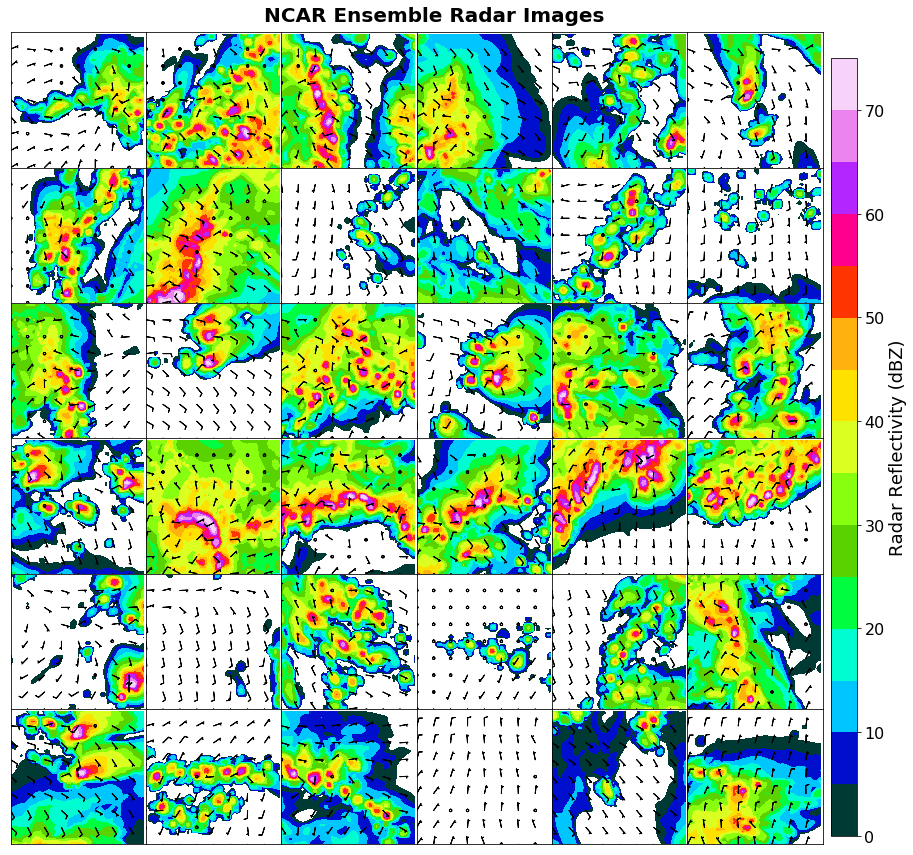

In [50]:
storm_samples = np.random.choice(storm_data.shape[0], 36, replace=False)
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(storm_data[storm_samples[a], :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
    ax.barbs(np.arange(0, 64, 8), np.arange(0, 64, 8), 
             storm_data[storm_samples[a], ::8, ::8, 3], storm_data[storm_samples[a], ::8, ::8, 4], length=4)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlim(0, 64)
    ax.set_ylim(0, 64)
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel("Radar Reflectivity (dBZ)", fontsize=18)
fig.suptitle("NCAR Ensemble Radar Images", 
             fontsize=20, fontweight="bold", y=0.98)
plt.savefig(out_path + "ncar_ens_random_radar.png", dpi=300, bbox_inches="tight")

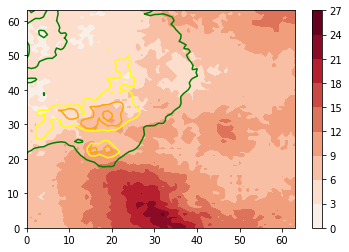

In [37]:
patches = xr.open_dataset(patch_files[-6])
dewp_dep = plt.contourf(patches["gen_patch"][8, :, :, 1] - patches["gen_patch"][8, :, :, 2], cmap="RdBu_r", vmin=-25, vmax=25)
plt.contour(patches["gen_patch"][2, :, :, 0], [20, 40, 50, 60], cmap=ListedColormap(["green", "yellow", "orange"]))
plt.colorbar(dewp_dep)

In [22]:
patch_files

['/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0001.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0005.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0010.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0001.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0005.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0010.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000002_epoch_0001.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000002_epoch_0005.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000002_epoch_0010.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000003_epoch_0001.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000003_epoch_0005.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000003_epoch_0010.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000006_epoch_0001.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000006_epoch_0005.nc',
 '/scratch/dgagne/storm_gan/gan_gen_patches_000006_epoch_0010.

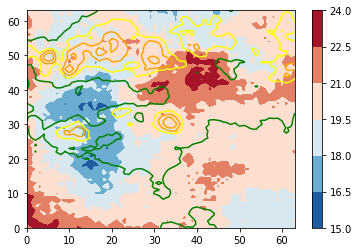

In [26]:
patches = xr.open_dataset(patch_files[-9])
p_num = 32
temp = plt.contourf(patches["gen_patch"][p_num, :, :, 2] - 273, cmap="RdBu_r")
plt.contour(patches["gen_patch"][p_num, :, :, 0], [20, 40, 50, 60], cmap=ListedColormap(["green", "yellow", "orange"]))
plt.colorbar(temp)
patches.close()

IndexError: index 27 is out of bounds for axis 0 with size 27

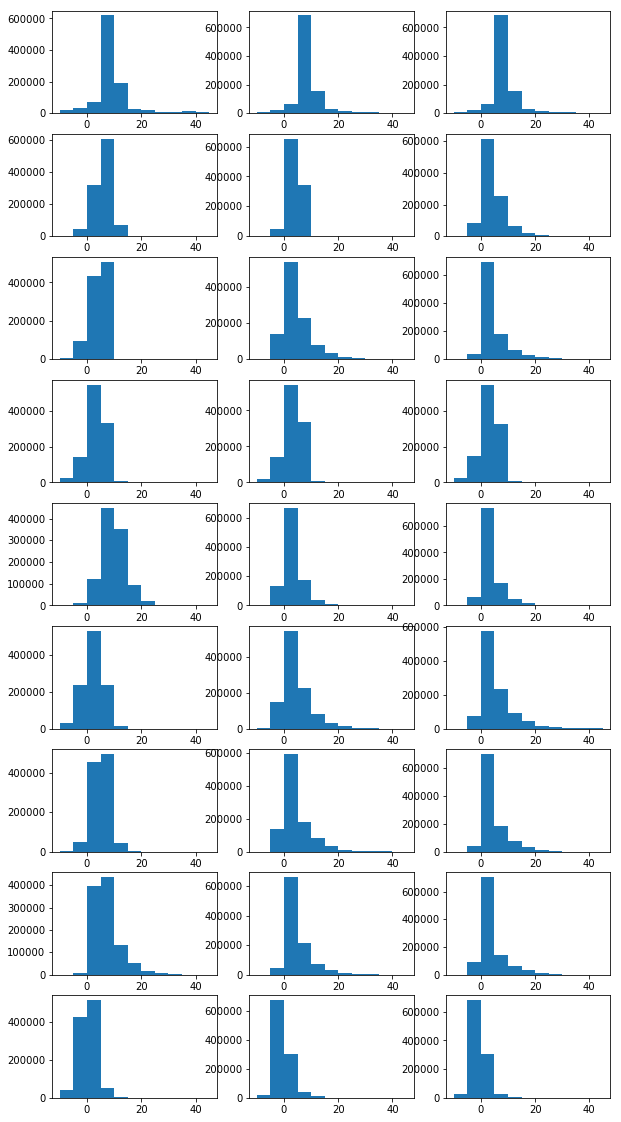

In [102]:
fig, axes = plt.subplots(len(patch_files) // 3, 3, figsize=(10, 20))
axef = axes.ravel()
for p, patch_file in enumerate(patch_files):
    patches = xr.open_dataset(patch_file)
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    dewp_dep = (patches["gen_patch"][:, :, :, 1] - patches["gen_patch"][:, :, :, 2]).values.ravel()
    axef[p].hist(dewp_dep, np.arange(-10, 50, 5))
    patches.close()

In [27]:
configs = []
epochs = []
for p, patch_file in enumerate(patch_files):
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    configs.append(config)
    epochs.append(epoch)
configs = np.unique(configs)
epochs = np.unique(epochs)

In [28]:
dewp_deps = pd.DataFrame(index=configs, columns=epochs, dtype=int)
for p, patch_file in enumerate(patch_files):
    patches = xr.open_dataset(patch_file)
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    dewp_deps.loc[config, epoch] = np.count_nonzero((patches["gen_patch"][:, :, :, 1] - patches["gen_patch"][:, :, :, 2]) < 0)
    dewp_deps.loc[config, epoch] /= patches["gen_patch"][:, :, :, 1].size
    patches.close()

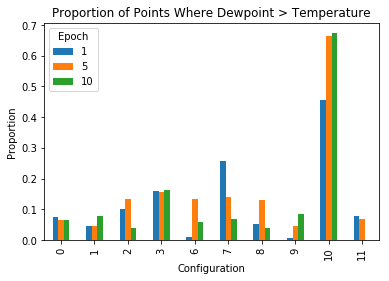

In [93]:
dewp_deps.plot(kind="bar")
plt.xlabel("Configuration")
plt.ylabel("Proportion")
plt.title("Proportion of Points Where Dewpoint > Temperature")
plt.legend(title="Epoch")
plt.savefig("/scratch/dgagne/storm_gan_images/dewp_temp_comp.png", dpi=200, bbox_inches="tight")

In [31]:
gan_model_path = "/scratch/dgagne/storm_gan_20170424/"
gen_model = load_model(gan_model_path + "gan_generator_000009_epoch_0010.h5")
enc_model = load_model(gan_model_path + "gan_encoder_000009_epoch_0010.h5")
disc_model = load_model(gan_model_path + "gan_discriminator_000009_0010.h5")

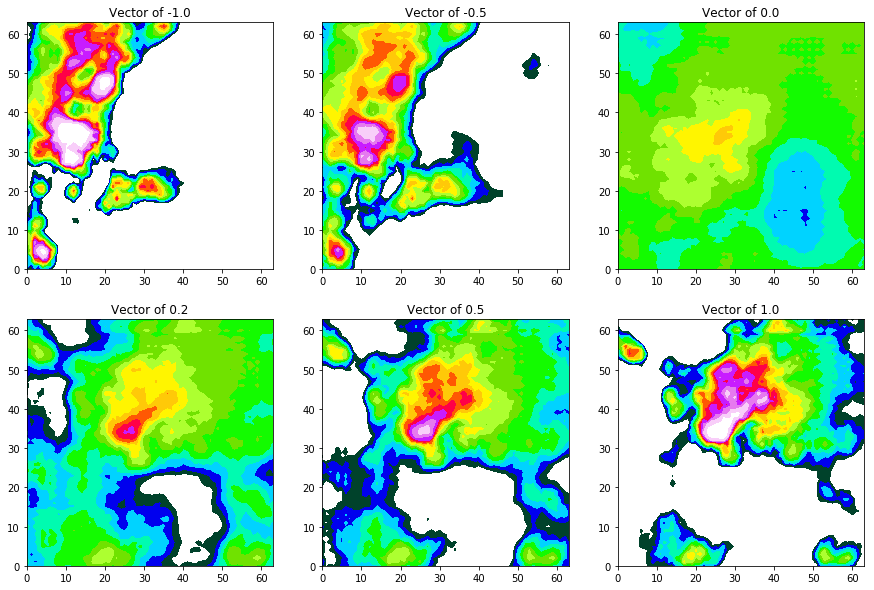

In [34]:
plt.figure(figsize=(15, 10))
for i, val in enumerate([-1, -0.5, 0, 0.25, 0.5, 1]):
    plt.subplot(2, 3, i + 1)
    plt.contourf(unscale_multivariate_data(gen_model.predict(np.ones((1, 100)) * val), min_vals, max_vals)[0, :, :, 0], 
                 np.arange(0, 75, 5), cmap="gist_ncar")
    plt.title("Vector of {0:0.1f}".format(val))

In [76]:
vec = np.random.uniform(-1, 1, size=(1, 100))
rand_change = vec + np.random.uniform(-0.2, 0.2, size=(1, 100))

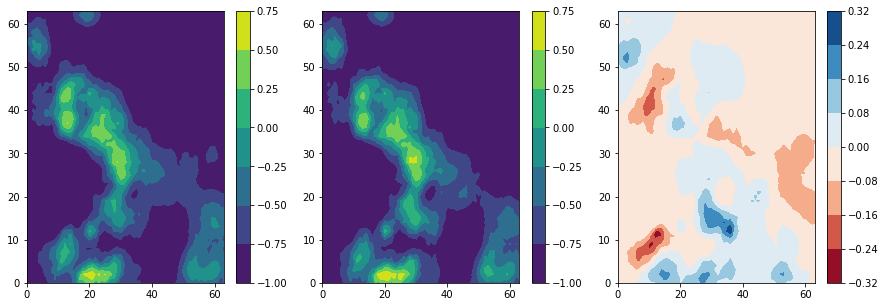

In [78]:
plt.figure(figsize=(15, 5))
#vec = np.random.uniform(-1, 1, size=(1, 100))
#rand_change = vec + np.random.uniform(-0.2, 0.2, size=(1, 100))
out_1 = gen_model.predict(vec)
out_2 = gen_model.predict(rand_change)
plt.subplot(1, 3, 1)
plt.contourf(out_1[0, :, :, 0])
plt.colorbar()
plt.subplot(1, 3, 2)
plt.contourf(out_2[0, :, :, 0])
plt.colorbar()
plt.subplot(1, 3, 3)
plt.contourf(out_2[0, :, :, 0] - out_1[0, :, :, 0], cmap="RdBu")
plt.colorbar()

In [14]:
recoded_storms = np.random.choice(storm_data.shape[0], 8, replace=False)

In [26]:
regen_storm_data = unscale_multivariate_data(gen_model.predict(enc_model.predict(rescaled_storm_data[recoded_storms])),
                                             min_vals, max_vals)

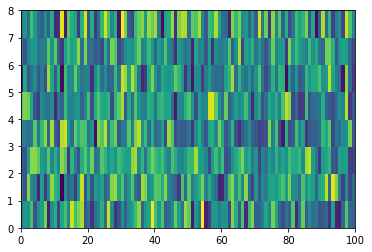

In [151]:
reduced_vector = enc_model.predict(rescaled_storm_data[recoded_storms])
plt.pcolormesh(reduced_vector)

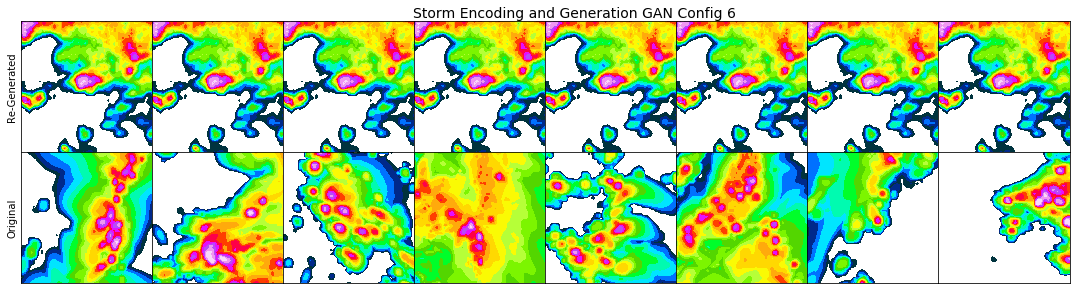

In [27]:
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
plt.subplots_adjust(0.02, 0.02, 0.93, 0.93, 0, 0)
for a in range(8):
    axes[0, a].contourf(regen_storm_data[a, :, :, 0],
                        np.arange(-15, 80, 5), cmap="gist_ncar")
    axes[1, a].contourf(storm_data[recoded_storms[a], :, :, 0], 
                        np.arange(-15, 80, 5), cmap="gist_ncar")
    axes[0, a].axes.get_xaxis().set_ticks([])
    axes[0, a].axes.get_yaxis().set_ticks([])
    axes[1, a].axes.get_xaxis().set_ticks([])
    axes[1, a].axes.get_yaxis().set_ticks([])
axes[0, 0].set_ylabel("Re-Generated")
axes[1, 0].set_ylabel("Original")
fig.suptitle("Storm Encoding and Generation GAN Config 6", y=0.98, fontsize=14)
plt.savefig("/scratch/dgagne/storm_gan_20170424/refl_gan_enc_gen_06.png", bbox_inches="tight", dpi=300)

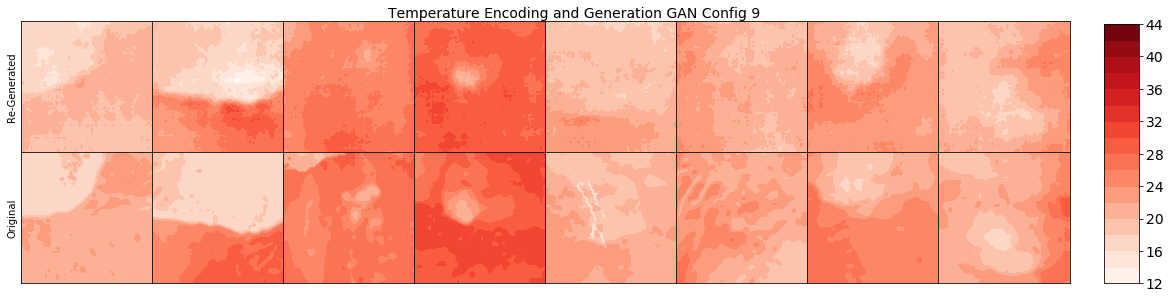

In [193]:
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
plt.subplots_adjust(0.02, 0.02, 0.93, 0.93, 0, 0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
for a in range(8):
    cont = axes[0, a].contourf(regen_storm_data[a, :, :, 1] - 273,
                        np.arange(12, 45, 2), cmap="Reds")
    axes[1, a].contourf(storm_data[recoded_storms[a], :, :, 1] - 273,
                        np.arange(12, 45, 2), cmap="Reds")
    axes[0, a].axes.get_xaxis().set_ticks([])
    axes[0, a].axes.get_yaxis().set_ticks([])
    axes[1, a].axes.get_xaxis().set_ticks([])
    axes[1, a].axes.get_yaxis().set_ticks([])
axes[0, 0].set_ylabel("Re-Generated")
axes[1, 0].set_ylabel("Original")
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Temperature Encoding and Generation GAN Config 9", y=0.98, fontsize=14)
plt.savefig("temp_gan_enc_gen_09.png", bbox_inches="tight", dpi=300)

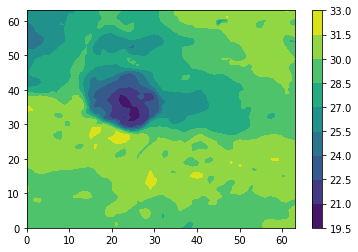

In [182]:
plt.contourf(storm_data[recoded_storms[3], :, :, 1] - 273)
plt.colorbar()

In [181]:
stacked = stack_gen_encoder(gen_model, enc_model)

In [205]:
stacked.compile("adam", mae_var)

In [204]:
def mae_var(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) + 0.1 * K.abs(K.var(y_true) - K.var(y_pred))

In [213]:
train_vals = np.random.uniform(-1, 1, size=(10000, 10))
stacked.fit(train_vals, train_vals, batch_size=512, epochs=2)

Epoch 1/2
10000/10000 [==============================] - 39s - loss: 0.0559      

In [30]:
gen_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              45056     
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 1024)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 512)         13107712  
_________________________________________________________________
activation_2 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
activation_3 (Activation)    (None, 8, 8, 256)         0         
__________

In [29]:
disc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        8064      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 512)         3277312   
__________

In [57]:
enc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       16128     
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 512)         3277312   
_________________________________________________________________
activation_9 (Activation)    (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 1024)        13108224  
__________

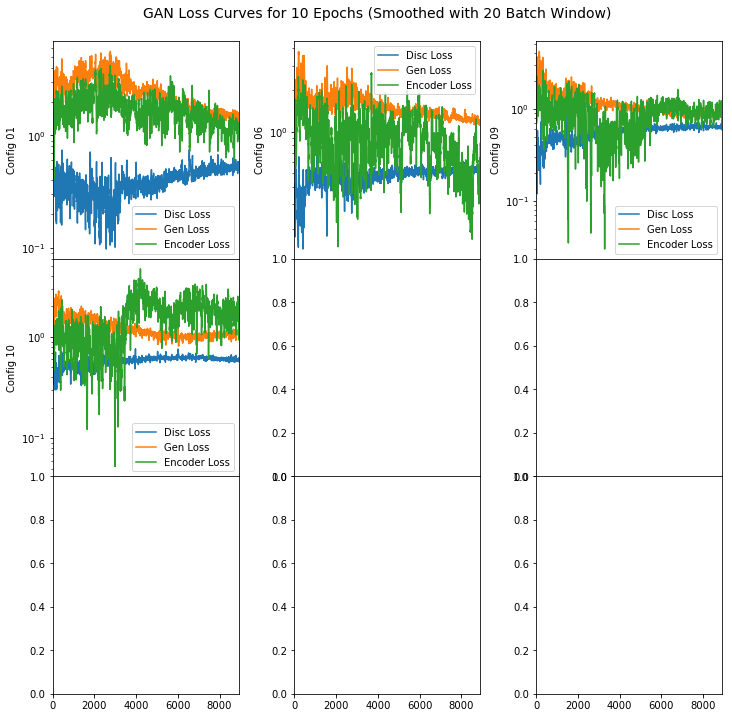

In [3]:
config_files = sorted(glob("/scratch/dgagne/storm_gan_20170424/gan_loss_history_*.csv"))
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.3)
axef = axes.ravel()
for c, config_file in enumerate(config_files):
    config = int(config_file[-10:-4])
    config_hist = pd.read_csv(config_file, parse_dates=["Time"])
    config_hist[["Disc Loss", "Gen Loss", "Encoder Loss"]].rolling(window=20).mean().plot(y=["Disc Loss", "Gen Loss", "Encoder Loss"], ax=axef[c])
    axef[c].set_yscale("log")
    axef[c].set_ylabel("Config {0:02d}".format(config))
plt.suptitle("GAN Loss Curves for 10 Epochs (Smoothed with 20 Batch Window)", fontsize=14, y=0.92)
plt.savefig("/scratch/dgagne/storm_gan_images/storm_gan_loss_curves.png", dpi=250, bbox_inches="tight")

In [67]:
config_files = sorted(glob("/scratch/dgagne/storm_gan/gan_loss_history_*.csv"))
for config_file in config_files:
    #print(config_file)
    config = int(config_file[-10:-4])
    config_hist = pd.read_csv(config_file, parse_dates=["Time"])
    print(config, pd.Timedelta(config_hist["Time"].values[-1] - config_hist["Time"].values[0]))

0 0 days 06:31:52.070500
1 0 days 06:28:21.336202
2 0 days 22:51:03.941724
3 0 days 23:01:00.693484
6 0 days 03:35:29.961891
7 0 days 03:35:53.042689
8 0 days 11:20:32.703980
9 0 days 11:14:01.711053
10 1 days 17:00:16.314551


In [197]:
config_info = pd.read_csv("/scratch/dgagne/storm_gan/gan_param_combos.csv", index_col="Index")

In [198]:
config_info

,min_data_width,leaky_relu_alpha,min_conv_filters,filter_width,learning_rate,beta_one,batch_size,generator_input_size
Index,,,,,,,,
0,2,0.2,64,5,0.0001,0.2,256,10
1,2,0.2,64,5,0.0001,0.2,256,100
2,2,0.2,128,5,0.0001,0.2,256,10
3,2,0.2,128,5,0.0001,0.2,256,100
4,2,0.2,256,5,0.0001,0.2,256,10
5,2,0.2,256,5,0.0001,0.2,256,100
6,4,0.2,64,5,0.0001,0.2,256,10
7,4,0.2,64,5,0.0001,0.2,256,100
8,4,0.2,128,5,0.0001,0.2,256,10


(array([  1.12694000e+05,   1.00740000e+04,   1.08620000e+04,
          1.29320000e+04,   1.37200000e+04,   1.56900000e+04,
          1.70840000e+04,   1.94360000e+04,   2.15360000e+04,
          2.21390000e+04,   2.31770000e+04,   2.14910000e+04,
          1.95720000e+04,   1.91210000e+04,   2.00860000e+04,
          2.10180000e+04,   2.15490000e+04,   2.11590000e+04,
          1.61600000e+04,   1.06850000e+04,   7.11700000e+03,
          4.82200000e+03,   3.31900000e+03,   2.31500000e+03,
          1.53600000e+03,   9.02000000e+02,   5.06000000e+02,
          2.55000000e+02,   7.20000000e+01,   1.10000000e+01]),
 array([-20.        , -16.65208333, -13.30416667,  -9.95625   ,
         -6.60833333,  -3.26041667,   0.0875    ,   3.43541667,
          6.78333333,  10.13125   ,  13.47916667,  16.82708333,
         20.175     ,  23.52291667,  26.87083333,  30.21875   ,
         33.56666667,  36.91458333,  40.2625    ,  43.61041667,
         46.95833333,  50.30625   ,  53.65416667,  57.0020

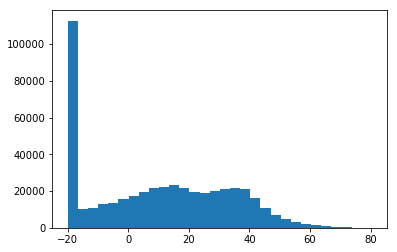

In [214]:
plt.hist(storm_data[::1000, :, :, 0].ravel(), 30)

(array([  7.29722300e+06,   1.01610200e+06,   8.14105000e+05,
          8.39101000e+05,   9.76512000e+05,   1.19937200e+06,
          1.46597600e+06,   1.74457100e+06,   1.98924300e+06,
          2.17126400e+06,   2.28358200e+06,   2.33673000e+06,
          2.34268600e+06,   2.31936300e+06,   2.27090000e+06,
          2.20750300e+06,   2.07909300e+06,   1.77351200e+06,
          1.31887900e+06,   9.09365000e+05,   6.10658000e+05,
          4.03980000e+05,   2.59806000e+05,   1.59011000e+05,
          9.08350000e+04,   4.79430000e+04,   2.20030000e+04,
          8.33800000e+03,   2.11600000e+03,   2.28000000e+02]),
 array([-20.        , -16.60660884, -13.21321767,  -9.81982651,
         -6.42643534,  -3.03304418,   0.36034698,   3.75373815,
          7.14712931,  10.54052048,  13.93391164,  17.32730281,
         20.72069397,  24.11408513,  27.5074763 ,  30.90086746,
         34.29425863,  37.68764979,  41.08104095,  44.47443212,
         47.86782328,  51.26121445,  54.65460561,  58.0479

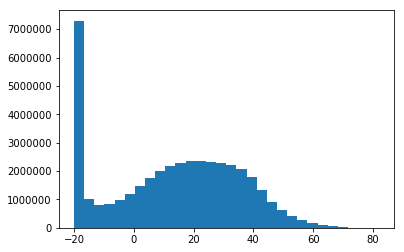

In [215]:
plt.hist(gen_data_scaled[:, :, :, 0].ravel(), 30)

In [124]:
gen_data = gen_model.predict(np.random.uniform(low=-1, high=1, size=(10000, 100)))

In [125]:

gen_data_scaled = unscale_multivariate_data(gen_data, min_vals, max_vals)

In [131]:
sampled_storms = np.random.choice(storm_data.shape[0], size=10000, replace=False)

{'boxes': [<matplotlib.lines.Line2D at 0x7f4cbfb4dfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4cbfb59a58>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4cbfb5ec50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f4cbfb5e438>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f4cbfb539e8>,
  <matplotlib.lines.Line2D at 0x7f4cbfaacb70>]}

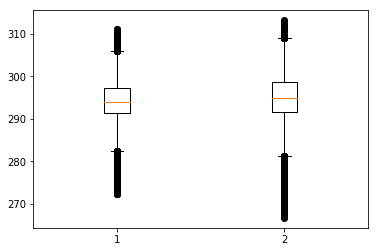

In [216]:
plt.boxplot([gen_data_scaled[:, :, :, 1].ravel(), storm_data[sampled_storms, :, :, 1].ravel()])

(array([[             nan,              nan,              nan,
                      nan,   1.00000000e+00,              nan,
           1.00000000e+00,   3.00000000e+00,   2.00000000e+00,
           1.00000000e+00,   5.00000000e+00,   5.00000000e+00,
           5.00000000e+00,   1.00000000e+01,   1.20000000e+01,
           2.00000000e+00,   3.00000000e+00,   1.00000000e+00,
                      nan,              nan],
        [             nan,              nan,              nan,
                      nan,   8.00000000e+00,   1.40000000e+01,
           2.90000000e+01,   3.80000000e+01,   4.70000000e+01,
           7.80000000e+01,   8.30000000e+01,   8.40000000e+01,
           8.80000000e+01,   7.40000000e+01,   3.90000000e+01,
           2.80000000e+01,   1.20000000e+01,   9.00000000e+00,
           2.00000000e+00,              nan],
        [             nan,              nan,   3.00000000e+00,
           1.10000000e+01,   3.60000000e+01,   7.50000000e+01,
           1.54000000e+02,

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


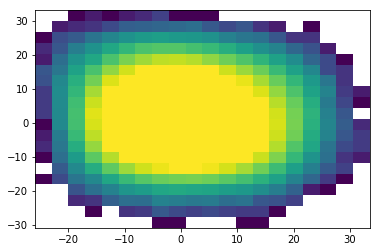

In [212]:
plt.hist2d(gen_data_scaled[:, :, :, 3].ravel(), 
           gen_data_scaled[:, :, :, 4].ravel(),
           bins=20, cmin=1, norm=colors.LogNorm(vmin=1, vmax=10000))

In [206]:
neg_dewp_dep = np.count_nonzero((storm_data[:, :, :, 1] - storm_data[:, :, :, 2]) < 0)
all_points = storm_data[:, :, :, 1].size
print(neg_dewp_dep / all_points)

0.0023751395394613012


In [42]:
x, y = np.meshgrid(np.arange(64) * 3, np.arange(64) * 3)
x_flat = x.flatten().reshape(-1, 1)
y_flat = y.flatten().reshape(-1, 1)

In [46]:
distances = np.sqrt((x_flat - x_flat.T) ** 2 + (y_flat - y_flat.T) ** 2)

In [63]:
var_dists = np.array([12, 15, 18, 21, 24, 30, 60, 90])
var_vals = np.zeros(var_dists.size)
for d, dist in enumerate(var_dists):
    valid_points = np.where(np.abs(distances-dist) < 0.5)
    var_vals[d] = np.mean((refl_data[:, valid_points[0]] - refl_data[:, valid_points[1]]) ** 2) / 2

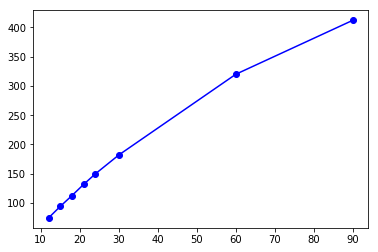

In [65]:
plt.plot(var_dists, var_vals, 'bo-')

In [61]:
refl_data = storm_data[:, :, :, 0].reshape(-1, 64 * 64)

In [62]:
refl_data.shape

(114229, 4096)